In [2]:
from DataLoader import *
from Visualization import *
from EstimateFundamentalMatrix import *
from EssentialMatrixFromFundamentalMatrix import *
from GetInliersRANSAC import *
from ExtractCameraPose import *
from LinearTriangulation import *
from DisambiguateCameraPose import *
from NonlinearTriangulation import *
import os

# Don't generate pyc codes
sys.dont_write_bytecode = True

In [3]:
dataDirPath = os.getcwd() + '/P3Data/'
images = loadImages(dataDirPath)
# displayImages(images, 5)


In [4]:
K = getCameraParams(dataDirPath)
print(K)

[[531.12215532   0.         407.19255084]
 [  0.         531.5417375  313.30871505]
 [  0.           0.           1.        ]]


In [5]:
featureMatchesList = parseMatchFiles(dataDirPath)

In [6]:
InlierList, OutlierList = ransac(featureMatchesList[0].matchPairs, 2000, 0.01)
matchPairsInliers = [featureMatchesList[0].matchPairs[i] for i in InlierList]
matchPairsOutliers = [featureMatchesList[0].matchPairs[i] for i in OutlierList]


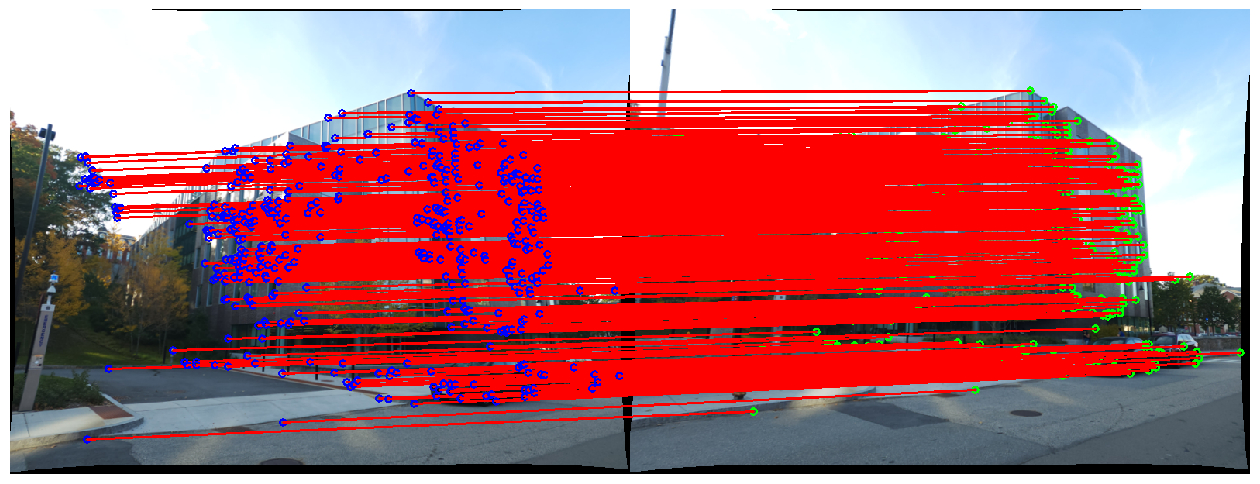

In [7]:
matchImage = drawMatchs(images[0], images[1], matchPairsInliers)

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.imshow(matchImage)
plt.show()

## Final Fundimental Matrix Calculated from inliers

In [8]:
x1s = []
x2s = []
for idx in range(len(matchPairsInliers)):
    x1s.append(matchPairsInliers[idx].coords1)
    x2s.append(matchPairsInliers[idx].coords2)
x1s = np.array(x1s)
x2s = np.array(x2s)

Fest = EstimateFundamentalMatrix(x1s, x2s)
print(Fest)


[[ 1.60230885e-09  2.81372002e-05 -1.20623951e-02]
 [-3.06486731e-05 -3.08683902e-06  3.36695804e-02]
 [ 1.38911863e-02 -3.18727955e-02 -9.98755233e-01]]


## Estimate Essential Matrix from Fundimental Matrix

In [9]:
Eest = EssentialFromFundamental(Fest, K)
print(Eest)

[[-0.00285513  0.56562173 -0.11924032]
 [-0.62026052 -0.0534933   0.76859644]
 [ 0.16752619 -0.81157309 -0.0283657 ]]


## Estimate Camera Pose

In [10]:
Rest, Test = extractCameraPose(Eest)
print(Rest)
print(Test)

[array([[ 0.25390093,  0.20074614,  0.94616875],
       [ 0.25111281, -0.95836341,  0.13594825],
       [ 0.9340646 ,  0.20307771, -0.29373929]]), array([[ 0.25390093,  0.20074614,  0.94616875],
       [ 0.25111281, -0.95836341,  0.13594825],
       [ 0.9340646 ,  0.20307771, -0.29373929]]), array([[ 0.9966782 ,  0.02158568,  0.0785278 ],
       [-0.02547984,  0.99847714,  0.04893036],
       [-0.07735202, -0.0507687 ,  0.9957104 ]]), array([[ 0.9966782 ,  0.02158568,  0.0785278 ],
       [-0.02547984,  0.99847714,  0.04893036],
       [-0.07735202, -0.0507687 ,  0.9957104 ]])]
[array([-0.81599366, -0.14722385, -0.55899864]), array([0.81599366, 0.14722385, 0.55899864]), array([-0.81599366, -0.14722385, -0.55899864]), array([0.81599366, 0.14722385, 0.55899864])]


## Triangulation Check for Cheirality Condition

In [11]:
Xest = []
for i in range(len(Rest)):
    X = LinearTriangulation(K, x1s, x2s, np.eye(3), np.zeros((3,1)), Rest[i], Test[i])
    Xest.append(X)

Rest, Test, Xest = disambiguateCameraPose(Rest, Test, Xest)


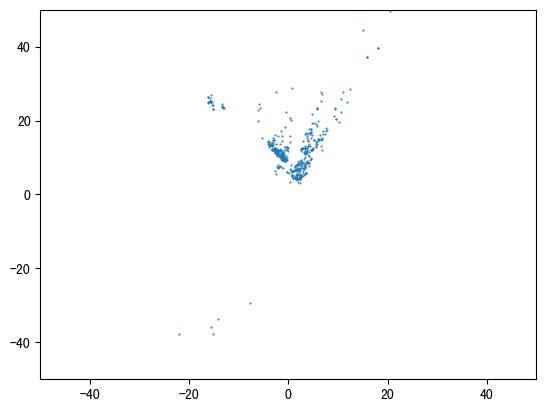

In [12]:
drawWorldPoints([Xest])
# drawWorldPoints(Xest)
# drawWorldPoints([Xest[0]])
# drawWorldPoints([Xest[1]])
# drawWorldPoints([Xest[2]])
# drawWorldPoints([Xest[3]])

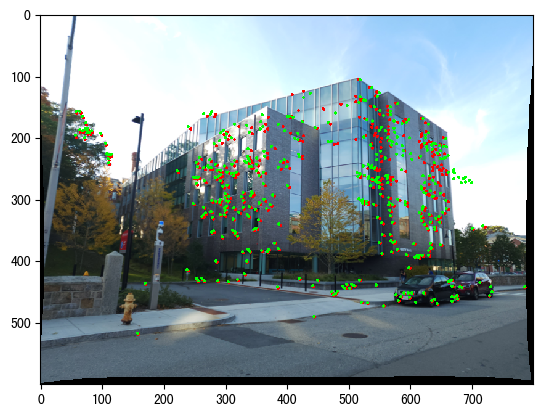

In [13]:
newImage = drawPoints(images[0], x1s, [255, 0, 0])

reprojPoints = reprojection(K, np.eye(3), np.zeros((3,1)), Xest)
newImage = drawPoints(newImage, reprojPoints, [0, 255, 0])

plt.imshow(newImage)
plt.show()

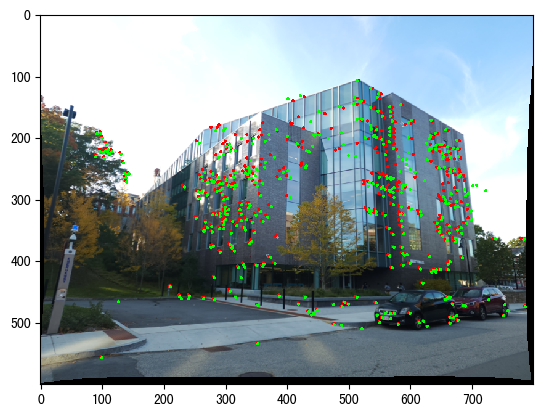

In [14]:
newImage2 = drawPoints(images[1], x2s, [255, 0, 0])

reprojPoints2 = reprojection(K, Rest, Test, Xest)
newImage2 = drawPoints(newImage2, reprojPoints2, [0, 255, 0])

plt.imshow(newImage2)
plt.show()

In [15]:
XestNonlinear = nonlinearTriangulation(K, np.eye(3), np.zeros((3,1)), Rest, Test, x1s, x2s, Xest)